# Preprocessing Module with Features Data
This module adds the target column of tremor to features data according to
MDS-UPDRS patients test.

## Required Imports

In [35]:
import re
import pickle


import pandas as pd
import numpy as np
import seaborn as sns

from src.settings import ROOT_DIR
from src.preprocessing.get_anon_id import get_anon_id
from src.utils.data_split import save_and_split

## Load Data
Loads Features and MDS-UPDRS

In [36]:
#Load Features
data: pd.DataFrame = pd.read_pickle(ROOT_DIR / 'data' / 'processed' / 'anon_imu_data_features.pkl')

#Load MDS-UPDRS
patients_mds:pd.DataFrame = pd.read_excel(ROOT_DIR / 'data' / 'raw' / 'patients_mdsupdrs_results.xlsx')
patients_mds_used_columns = ['Cédula','Temblor postural – Mano derecha','Temblor postural – Mano izquierda','Temblor de acción – Mano derecha','Temblor de acción – Mano izquierda']
patients_mds = patients_mds[patients_mds_used_columns]

In [37]:
patients_mds['Cédula'] = patients_mds['Cédula'].astype('string')

## MDS-UPDRS Target extraction

Is necessary to split patients and controls to cross ids with MDS-UPDRS test:

In [38]:
patients_mds['anon_id'] = patients_mds['Cédula'].apply(get_anon_id)
patients_mds_used_columns.pop(0)

'Cédula'

In [39]:
tremor_list = []
for i in range(len(patients_mds)):
    tremor_list.append(1 if patients_mds.loc[i, patients_mds_used_columns].sum() > 0 else 0)

In [40]:
patients_mds['tremor'] = tremor_list
patients_mds = patients_mds[['anon_id', 'tremor']]

In [41]:
patients_mds['tremor'].value_counts()

tremor
0    51
1    39
Name: count, dtype: int64

In [42]:
patients_mds = patients_mds[patients_mds['anon_id'].ne('')]

In [43]:
patients = data[data['PD'] == 1].copy()
controls = data[data['PD'] == 0].copy()

In [44]:
len(patients)

10284

In [45]:
mds_id_list = set(patients_mds['anon_id'].tolist())
df_id_list = set(patients['anon_id'].tolist())
intersection_ids = df_id_list.intersection(mds_id_list)
print(len(intersection_ids))

61


In [46]:
patients_mds = patients_mds[patients_mds['anon_id'].isin(intersection_ids)]

In [47]:
print('Patients registers before merge:',len(patients))
patients = pd.merge(patients, patients_mds, how='inner')
patients.dropna(inplace=True)
print('Patients registers after merge:',len(patients))

Patients registers before merge: 10284
Patients registers after merge: 7081


In [48]:
controls['tremor'] = [0 for i in range(len(controls))]

In [49]:
tremor_data = pd.concat([patients, controls])

In [50]:
len(tremor_data)

16547

## Removal of not necessary columns: Spine columns

In [51]:
pattern = re.compile(".*.spine")
dropable_columns = list(filter(pattern.match, tremor_data.columns.tolist()))
dropable_columns

['imu_gyroX_spine_mean',
 'imu_gyroX_spine_std',
 'imu_gyroX_spine_mean_abs_dev',
 'imu_gyroX_spine_min',
 'imu_gyroX_spine_max',
 'imu_gyroX_spine_range',
 'imu_gyroX_spine_median',
 'imu_gyroX_spine_median_abs_dev',
 'imu_gyroX_spine_interquartile_range',
 'imu_gyroX_spine_negative_count',
 'imu_gyroX_spine_positive_count',
 'imu_gyroX_spine_above_mean_count',
 'imu_gyroX_spine_local_maxima_count',
 'imu_gyroX_spine_skewness',
 'imu_gyroX_spine_kurtosis',
 'imu_gyroY_spine_mean',
 'imu_gyroY_spine_std',
 'imu_gyroY_spine_mean_abs_dev',
 'imu_gyroY_spine_min',
 'imu_gyroY_spine_max',
 'imu_gyroY_spine_range',
 'imu_gyroY_spine_median',
 'imu_gyroY_spine_median_abs_dev',
 'imu_gyroY_spine_interquartile_range',
 'imu_gyroY_spine_negative_count',
 'imu_gyroY_spine_positive_count',
 'imu_gyroY_spine_above_mean_count',
 'imu_gyroY_spine_local_maxima_count',
 'imu_gyroY_spine_skewness',
 'imu_gyroY_spine_kurtosis',
 'imu_gyroZ_spine_mean',
 'imu_gyroZ_spine_std',
 'imu_gyroZ_spine_mean_abs_

In [52]:
tremor_data.drop(columns=dropable_columns)

,anon_id,date_measure,window_number,first_timestamp,imu_gyroX_right_mean,imu_gyroX_right_std,imu_gyroX_right_mean_abs_dev,imu_gyroX_right_min,imu_gyroX_right_max,imu_gyroX_right_range,...,imu_angularZ_right_median_abs_dev,imu_angularZ_right_interquartile_range,imu_angularZ_right_negative_count,imu_angularZ_right_positive_count,imu_angularZ_right_above_mean_count,imu_angularZ_right_local_maxima_count,imu_angularZ_right_skewness,imu_angularZ_right_kurtosis,PD,tremor
0,9,2023-9-29-11-53-21,1,0.0,344.527504,2066.933206,1375.765062,-5573.486673,4888.726779,10462.213452,...,0.209291,0.425664,24,26,24,44,0.102181,-0.532252,1,0
1,9,2023-9-29-11-53-21,2,532.0,-19.660417,1231.834050,996.842663,-3009.424803,2401.841438,5411.266241,...,0.191976,0.375723,25,25,22,44,0.379426,-0.486720,1,0
2,9,2023-9-29-11-53-21,3,1029.0,312.616200,1460.410867,1236.003103,-3009.424803,3060.657605,6070.082407,...,0.162759,0.319542,32,18,27,45,0.555760,0.529645,1,0
3,9,2023-9-29-11-53-21,4,1587.0,504.363670,1551.660978,1195.522472,-3127.877221,3060.657605,6188.534825,...,0.305800,0.638696,28,22,21,45,0.073120,-0.614050,1,0
4,9,2023-9-29-11-53-21,5,2121.0,-775.488526,1733.126911,1391.358979,-5263.676001,1333.368845,6597.044846,...,0.266286,0.575470,25,25,20,44,-0.137422,-0.191926,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19745,179,2023-6-17-10-39-17,19746,38028.0,-167.729124,3939.147407,3227.879392,-7919.130606,6424.632557,14343.763163,...,0.074732,0.168877,17,33,32,46,-0.692138,-0.696569,0,0
19746,179,2023-6-17-10-39-17,19747,39053.0,193.755568,3968.559630,3218.047860,-7904.588992,6424.632557,14329.221549,...,0.078395,0.176189,19,31,30,46,-0.525425,-0.718006,0,0
19747,179,2023-6-17-10-39-17,19748,40080.0,79.063830,4231.055000,3408.628614,-7904.588992,7376.909949,15281.498941,...,0.089300,0.190441,21,29,27,46,-0.470150,-0.799359,0,0
19748,179,2023-6-17-10-39-17,19749,41105.0,247.017182,4127.022986,3346.668836,-7518.233967,7376.909949,14895.143916,...,0.088738,0.170784,22,28,27,46,-0.359791,-0.939138,0,0


## Feature Selection

In [53]:
temp = tremor_data[tremor_data.columns.tolist()[4:]].copy()

In [54]:
correlation = tremor_data[tremor_data.columns.tolist()[4:]].corr().abs()['tremor']

In [55]:
best_correlations_columns = []
for index, value in correlation.items():
    if value > 0.3:
        best_correlations_columns.append(index)

best_correlations_columns

['imu_gyroX_right_std',
 'imu_gyroX_right_mean_abs_dev',
 'imu_gyroX_right_min',
 'imu_gyroX_right_max',
 'imu_gyroX_right_range',
 'imu_gyroX_right_median_abs_dev',
 'imu_gyroX_right_interquartile_range',
 'imu_accY_right_std',
 'imu_accY_right_mean_abs_dev',
 'imu_accY_right_range',
 'imu_accY_right_median_abs_dev',
 'imu_accY_right_interquartile_range',
 'imu_accZ_right_std',
 'imu_accZ_right_mean_abs_dev',
 'imu_accZ_right_max',
 'imu_accZ_right_range',
 'imu_accZ_right_median_abs_dev',
 'imu_accZ_right_interquartile_range',
 'imu_angularZ_right_std',
 'imu_angularZ_right_mean_abs_dev',
 'imu_angularZ_right_min',
 'imu_angularZ_right_max',
 'imu_angularZ_right_range',
 'imu_angularZ_right_median_abs_dev',
 'imu_angularZ_right_interquartile_range',
 'PD',
 'tremor']

In [56]:
len(best_correlations_columns)

27

<Axes: >

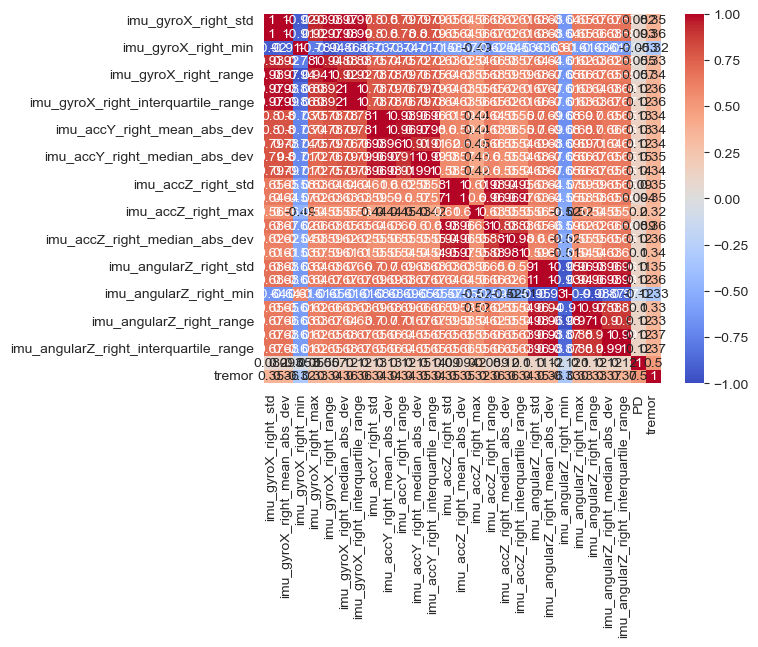

In [57]:
tremor_data = tremor_data[best_correlations_columns]
sns.heatmap(tremor_data.corr(), annot = True, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm')

### Drop of highly correlated columns

In [58]:
correlation = tremor_data.corr().abs()
upper = correlation.where(np.triu(np.ones(correlation.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
to_drop

['imu_gyroX_right_mean_abs_dev',
 'imu_gyroX_right_range',
 'imu_gyroX_right_median_abs_dev',
 'imu_gyroX_right_interquartile_range',
 'imu_accY_right_mean_abs_dev',
 'imu_accY_right_range',
 'imu_accY_right_median_abs_dev',
 'imu_accY_right_interquartile_range',
 'imu_accZ_right_mean_abs_dev',
 'imu_accZ_right_range',
 'imu_accZ_right_median_abs_dev',
 'imu_accZ_right_interquartile_range',
 'imu_angularZ_right_mean_abs_dev',
 'imu_angularZ_right_min',
 'imu_angularZ_right_max',
 'imu_angularZ_right_range',
 'imu_angularZ_right_median_abs_dev',
 'imu_angularZ_right_interquartile_range']

In [59]:
len(to_drop)

18

In [60]:
tremor_data.drop(to_drop, axis=1, inplace=True)

In [61]:
#PD is not the target of this module so it will be deleted
tremor_data.drop(columns=['PD'], inplace=True)

<Axes: >

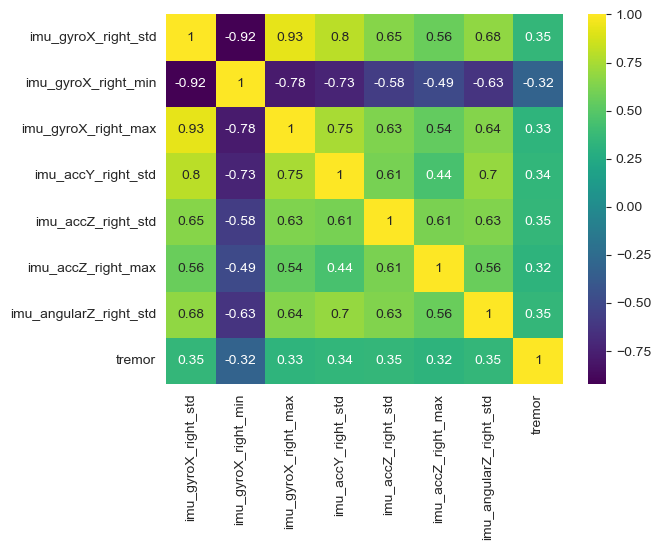

In [62]:
sns.heatmap(tremor_data.corr(), annot = True, cmap= 'viridis')

## Features Mirroring
Due to the chosen features only focused on right limb, is necessary to keep on mind that a patient could
have tremor on his left limb and using the selected features is not possible to identify that PD symptom.

In [63]:
right_cols = tremor_data.columns.tolist()
left_cols = [col.replace('right', 'left') for col in right_cols]

for col in left_cols:
    tremor_data[col] = temp[col]

In [64]:
tremor_data.columns

Index(['imu_gyroX_right_std', 'imu_gyroX_right_min', 'imu_gyroX_right_max',
       'imu_accY_right_std', 'imu_accZ_right_std', 'imu_accZ_right_max',
       'imu_angularZ_right_std', 'tremor', 'imu_gyroX_left_std',
       'imu_gyroX_left_min', 'imu_gyroX_left_max', 'imu_accY_left_std',
       'imu_accZ_left_std', 'imu_accZ_left_max', 'imu_angularZ_left_std'],
      dtype='object')

In [67]:
tremor_col = tremor_data.pop('tremor')
tremor_data.insert(len(tremor_data.columns), 'tremor', tremor_col)

<Axes: >

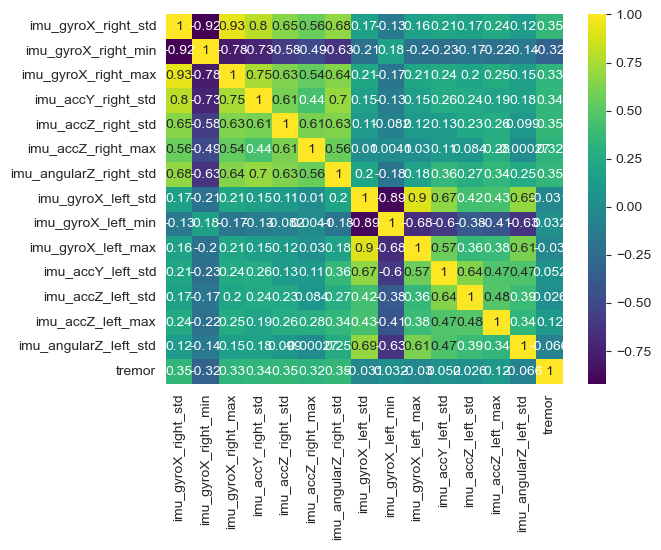

In [68]:
sns.heatmap(tremor_data.corr(), annot = True, cmap= 'viridis')

## Save data

In [69]:
save_and_split(tremor_data, 'tremor-features')